<a href="https://colab.research.google.com/github/espartaca75-prog/Optmizacion_dinamica_discreta/blob/main/05_COD_Euler_Ejemplo_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo 5

---



In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# --- 1. CONFIGURACIÓN SIMBÓLICA ---
# Definimos los símbolos para el modelo forestal
xt, ct, xt_next, ct_next = sp.symbols('x_t c_t x_{t+1} c_{t+1}')
alpha, gamma = sp.symbols('alpha gamma', positive=True)
Vt, Vt_next = sp.symbols('V_t V_{t+1}', cls=sp.Function)

# Definimos las funciones base
f = -sp.exp(-gamma * ct)      # Utilidad exponencial (sacrificio de extracción)
g = alpha * xt - ct           # Dinámica biológica del bosque

# Planteo de Bellman
bellman = f + Vt_next(xt_next)
print(f"Problema: Vt(xt) = max {{ {f} + Vt+1({g}) }}")

Problema: Vt(xt) = max { -exp(-c_t*gamma) + Vt+1(alpha*x_t - c_t) }


In [3]:
# --- ALGORITMO DE DESCUBRIMIENTO (EULER) ---
# Paso 1: CPO (derivando respecto al control ct)
cpo_expr = sp.Eq(sp.diff(f, ct) + sp.diff(Vt_next(xt_next), xt_next) * sp.diff(g, ct), 0)
print("CPO: ")
cpo_expr

CPO: 


Eq(gamma*exp(-c_t*gamma) - Derivative(V_{t+1}(x_{t+1}), x_{t+1}), 0)

In [4]:
#despejamos el valor futuro marginal
val_futuro_marginal_list = sp.solve(cpo_expr, sp.diff(Vt_next(xt_next), xt_next))
val_futuro_marginal = val_futuro_marginal_list[0]
print(f"Expresión dVt+1/dxt+1 hallada: ")
val_futuro_marginal

Expresión dVt+1/dxt+1 hallada: 


gamma*exp(-c_t*gamma)

In [5]:
# Paso 2: Benveniste-Scheinkman (Teorema de la Envolvente)
bs_expr = sp.diff(f, xt) + sp.diff(Vt_next(xt_next), xt_next) * sp.diff(g, xt)
print(f"Ecuación de Benveniste-Scheinkman, dVt/dxt=")
bs_expr

Ecuación de Benveniste-Scheinkman, dVt/dxt=


alpha*Derivative(V_{t+1}(x_{t+1}), x_{t+1})

In [6]:
#Reemplazando la el valor futuro marginal en la Ecuación de Benveniste-Scheinkman
bs_sustituido = bs_expr.subs(sp.diff(Vt_next(xt_next), xt_next), val_futuro_marginal)
print("dVt/dxt=")
bs_sustituido

dVt/dxt=


alpha*gamma*exp(-c_t*gamma)

In [7]:
#PASO 3: ADELANTO TEMPORAL DE B Y S
bs_adelantado = bs_sustituido.subs(ct, ct_next)
bs_adelantado

alpha*gamma*exp(-c_{t+1}*gamma)

In [8]:
# PASO 4: SUSTITUCIÓN FINAL EN CPO
# reemplazamos bs_adelantado en la CPO original y encontramos la ec. de Euler
euler_eq = sp.Eq(val_futuro_marginal, alpha * val_futuro_marginal.subs(ct, ct_next))
euler_eq

Eq(gamma*exp(-c_t*gamma), alpha*gamma*exp(-c_{t+1}*gamma))

In [9]:
#despejamos ct+1
euler_descubierta_list = sp.solve(euler_eq, ct_next)
euler_descubierta = euler_descubierta_list[0]
euler_descubierta_simplified = sp.simplify(sp.expand_log(euler_descubierta, force=True))
print(f"La ecuación de Euler es {ct_next}=")
euler_descubierta_simplified

La ecuación de Euler es c_{t+1}=


c_t + log(alpha)/gamma

In [10]:
# --- RESOLUCIÓN DEL SISTEMA EN DIFERENCIAS ---
#definimos los símbolos necesarios
t = sp.symbols('t', integer=True)
T_sym = sp.symbols('T', integer=True)
c_func = sp.Function('c')(t)
x_func = sp.Function('x')(t)

In [11]:
# Resolvemos la trayectoria del control (Aritmética)
sol_c = sp.rsolve(sp.Eq(c_func.subs(t, t+1), euler_descubierta_simplified.subs(ct, c_func)), c_func, {c_func.subs(t, 0): sp.Symbol('c_0')})
sol_c

c_0 + t*log(alpha)/gamma

In [12]:
# Resolvemos la trayectoria del estado (Movimiento)
mov_eq = sp.Eq(x_func.subs(t, t+1), alpha * x_func - sol_c)
sol_x = sp.rsolve(mov_eq, x_func, {x_func.subs(t, 0): sp.Symbol('x_0')})
sol_x.simplify()

(alpha*c_0*gamma + alpha**t*(alpha**2*gamma*x_0 - alpha*c_0*gamma - 2*alpha*gamma*x_0 + c_0*gamma + gamma*x_0 - log(alpha)) - c_0*gamma + (alpha*t - t + 1)*log(alpha))/(gamma*(alpha**2 - 2*alpha + 1))

In [13]:
# --- ANCLAJE TERMINAL (c_T = x_{T+1}) ---
# Condición de equilibrio para utilidad y residuo simétricos
cond_terminal = sp.Eq(sol_c.subs(t, T_sym), sol_x.subs(t, T_sym + 1))
c0_analitico = sp.solve(cond_terminal, sp.Symbol('c_0'))
print("Fórmula de c0 hallada: ")
c0_analitico[0]

Fórmula de c0 hallada: 


(alpha**(T + 1)*gamma*x_0 - 2*alpha**(T + 2)*gamma*x_0 + alpha**(T + 3)*gamma*x_0 + log(alpha**(-T*alpha**2 + 3*T*alpha - 2*T + alpha - alpha**(T + 1))))/(gamma*(alpha**2 - 3*alpha - alpha**(T + 1) + alpha**(T + 2) + 2))

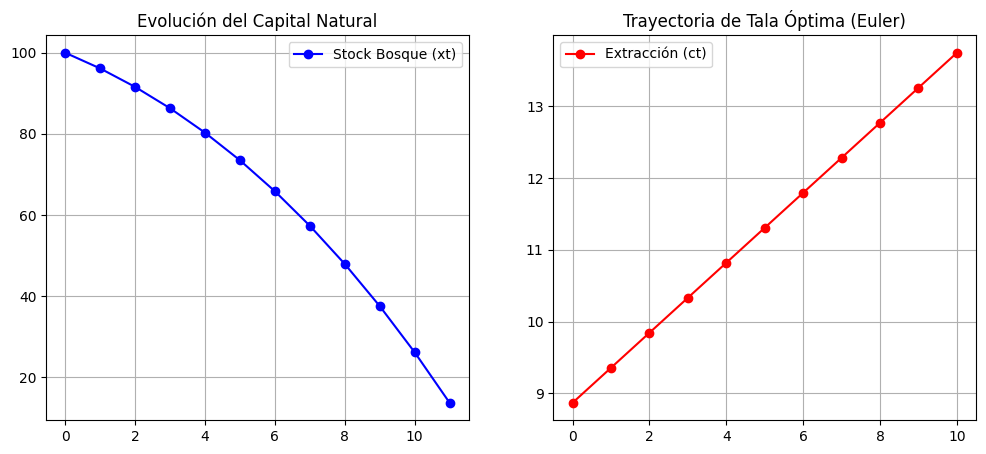


TABLA DE TRAYECTORIA ÓPTIMA FORESTAL
 Periodo  Stock (xt)  Extracción (ct)
       0  100.000000         8.868605
       1   96.131395         9.356506
       2   91.581459         9.844408
       3   86.316123        10.332310
       4   80.299620        10.820211
       5   73.494390        11.308113
       6   65.860996        11.796015
       7   57.358031        12.283916
       8   47.942017        12.771818
       9   37.567300        13.259720
      10   26.185945        13.747621


In [14]:
# --- EJECUCIÓN NUMÉRICA Y TRAYECTORIAS ---
params = {sp.Symbol('x_0'): 100, alpha: 1.05, gamma: 0.1, T_sym: 10}
c0_num = float(c0_analitico[0].subs(params))

c_vals = [float(sol_c.subs({**params, sp.Symbol('c_0'): c0_num, t: i})) for i in range(params[T_sym] + 1)]
x_vals = [float(sol_x.subs({**params, sp.Symbol('c_0'): c0_num, t: i})) for i in range(params[T_sym] + 2)]

# Visualización
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_vals, 'bo-', label='Stock Bosque (xt)')
plt.title('Evolución del Capital Natural'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(c_vals, 'ro-', label='Extracción (ct)')
plt.title('Trayectoria de Tala Óptima (Euler)'); plt.grid(True); plt.legend()
plt.show()

# Tabla de resultados
df = pd.DataFrame({'Periodo': range(params[T_sym] + 1), 'Stock (xt)': x_vals[:-1], 'Extracción (ct)': c_vals})
print("\nTABLA DE TRAYECTORIA ÓPTIMA FORESTAL")
print(df.to_string(index=False))